In [23]:
import os
import glob
import json
import datetime as dt
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

In [2]:
df_teams = sql.df_from_query("""
    SELECT * from teams
""")
df_teams.head()

,team_id,display_name,conference,location,year_start,year_end
0,abilene-christian,Abilene Christian,Southland,"Abilene, Texas",1971,2020
1,air-force,Air Force,MWC,"USAF Academy, Colorado",1958,2020
2,akron,Akron,MAC,"Akron, Ohio",1902,2020
3,alabama-am,Alabama A&M,SWAC,"Normal, Alabama",2000,2020
4,alabama,Alabama,SEC,"Tuscaloosa, Alabama",1913,2020


In [3]:
df_games = sql.df_from_query("""
    SELECT * from game_data
    """
)
print(df_games.shape)
df_games.head()

(54760, 39)


,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,13,-1,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,5,-1,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,-1,-1,...,17,22,13,16,11,27,18,1,31,98.36
3,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,-1,-1,...,10,18,5,21,8,16,5,5,24,80.44
4,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,-1,-1,...,16,19,10,25,12,22,8,8,19,77.64


In [4]:
df_reddit = sql.df_from_query("""
    SELECT date,gid,is_postgame,ups,num_comments from gamethreads
    """
)
print(df_reddit.shape)
df_reddit.head()

(14387, 5)


,date,gid,is_postgame,ups,num_comments
0,2017-11-10,2017-11-10_alabama-birmingham_jacksonville,True,9,0
1,2017-11-10,2017-11-10_alabama_memphis,False,6,81
2,2017-11-10,2017-11-10_albany-ny_iona,False,7,8
3,2017-11-10,2017-11-10_arizona_northern-arizona,False,13,82
4,2017-11-10,2017-11-10_austin-peay_vanderbilt,False,4,2


In [5]:
df_comments = sql.df_from_query("""
    SELECT gid,is_postgame,author,author_flair from gamethread_comments
""")
# df_comments.author_flair.head(20)
df_comments.author_flair = df_comments.author_flair.apply(lambda x: [x.strip('"') for x in x.strip('{}').split(',')])
print(df_comments.shape)
df_comments.head()

(387257, 4)


,gid,is_postgame,author,author_flair
0,2019-11-06_binghamton_cornell,True,CaffeinationGoat,"[Connecticut Huskies, Binghamton Bearcats]"
1,2019-11-06_binghamton_cornell,True,cheesoidhateself,[Cornell Big Red]
2,2019-11-06_binghamton_cornell,True,PAPA_JOHNS_ZIMBABWE,[NJIT Highlanders]
3,2019-11-06_binghamton_cornell,True,IsYouWitItYaBish,[Wisconsin Badgers]
4,2019-11-06_boston-college_wake-forest,False,mrfixit420,[Wake Forest Demon Deacons]


In [6]:
flairs = pd.Series([x for subl in df_comments.drop_duplicates('author').author_flair.values.tolist() for x in subl])
print(flairs.nunique())
flairs.value_counts().head(20)

591


                              5479
Michigan Wolverines            976
Michigan State Spartans        860
North Carolina Tar Heels       711
Kentucky Wildcats              685
Kansas Jayhawks                659
Purdue Boilermakers            561
Virginia Cavaliers             530
Duke Blue Devils               510
Indiana Hoosiers               449
Wisconsin Badgers              445
Maryland Terrapins             413
Illinois Fighting Illini       400
Tennessee Volunteers           389
NC State Wolfpack              379
Ohio State Buckeyes            373
Auburn Tigers                  348
Virginia Tech Hokies           346
Syracuse Orange                343
West Virginia Mountaineers     333
dtype: int64

In [7]:
team_ids = df_teams.team_id.values.tolist()
subs = json.load(open('../data/flair_substitutions.json'))
mapping = {}
for flair in flairs.value_counts().index:
    parts = flair.lower().replace('&','').replace('.','').replace("'",'').strip().split()
    for i in range(len(parts)):
        f = '-'.join(parts[:len(parts)-i])
        if f in team_ids and f not in mapping:
            mapping[f] = flair
            break
        if flair in subs and subs[flair] in team_ids and subs[flair] not in mapping:
            mapping[subs[flair]] = flair
            break
print(len(mapping))
pd.Series(flairs[~flairs.isin(mapping.values())]).value_counts().head(20)
# mapping

295


                             5479
Final Four                     50
Big East                       37
Big Ten                        30
Poll Veteran                   25
r                              20
CollegeBasketball              19
March Madness                  17
Big 12                         11
Bellarmine Knights             11
ACC                            11
NCAA                            9
American                        8
Atlantic 10                     7
Colorado Mines Orediggers       6
MAC                             6
Johns Hopkins Blue Jays         6
SEC                             6
UNC Wilmington Seahawks         6
MIT Engineers                   6
dtype: int64

In [8]:
df_comments.author_flair.head()
flair_counts = {}
authors = df_comments.drop_duplicates('author')[['author','author_flair']]
for tid in mapping:
    flair_counts[tid] = authors.author_flair.apply(lambda x:mapping[tid] in x).sum()
for t,c in sorted(flair_counts.items(), key=lambda x:x[1], reverse=True)[:10]:
    print(f"{c:4d} {t}")

 976 michigan
 860 michigan-state
 711 north-carolina
 685 kentucky
 659 kansas
 561 purdue
 530 virginia
 510 duke
 449 indiana
 445 wisconsin


In [9]:
def get_nauthors(row):
    tid1, tid2 = row.gid.split('_')[1:]
    return flair_counts.get(tid1,5) + flair_counts.get(tid2,5)
df_reddit["nauthors"] = df_reddit.apply(get_nauthors, axis=1)
df_reddit["norm_num_comments"] = df_reddit.num_comments / np.sqrt(df_reddit.nauthors)
df_reddit.query('nauthors>1000 & num_comments<20')

,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments
3690,2018-02-06,2018-02-06_iowa_michigan-state,True,2,7,1176,0.204124
3698,2018-02-06,2018-02-06_michigan_northwestern,True,11,8,1048,0.247121
3929,2018-02-13,2018-02-13_auburn_kentucky,False,1,2,1033,0.062227
4510,2018-03-02,2018-03-02_michigan_nebraska,True,1,3,1163,0.087969
12353,2020-01-09,2020-01-09_north-carolina_north-carolina-state,True,21,10,1090,0.302891


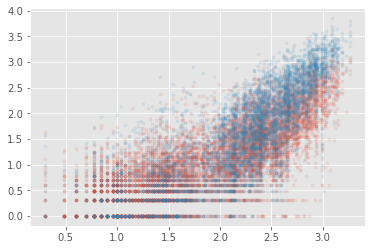

In [10]:
plt.figure()
plt.scatter(np.log10(df_reddit.nauthors[df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
plt.scatter(np.log10(df_reddit.nauthors[~df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[~df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
# plt.gca().set_ylim(0,2000)

Text(0.5, 0, 'log10((#comments + 1) / sqrt(nauthors))')

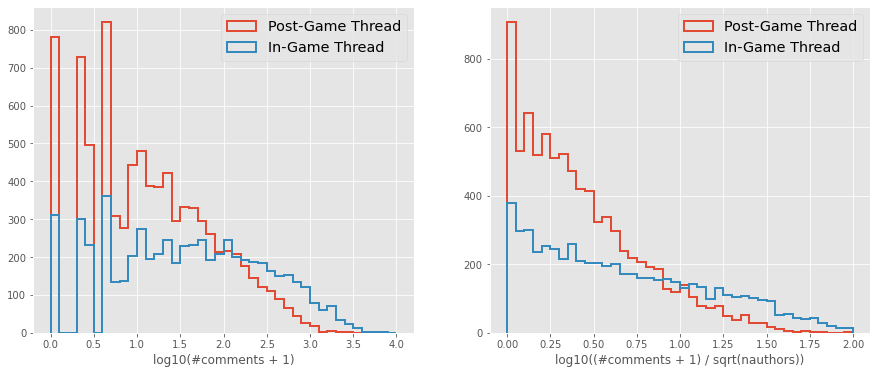

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(np.log10(df_reddit[df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="Post-Game Thread")
axs[0].hist(np.log10(df_reddit[~df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="In-Game Thread")
axs[0].legend(fontsize='x-large')
axs[0].set_xlabel("log10(#comments + 1)", fontsize='large')
axs[1].hist(np.log10(df_reddit[df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="Post-Game Thread")
axs[1].hist(np.log10(df_reddit[~df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="In-Game Thread")
axs[1].legend(fontsize='x-large')
axs[1].set_xlabel("log10((#comments + 1) / sqrt(nauthors))", fontsize='large')

In [12]:
FRAC = 0.7
first, second = utils.partition_games(df_games, frac=FRAC)
print(df_games.iloc[first].shape[0], df_games.iloc[second].shape[0])

38328 16432


In [13]:
season_stats_dict = utils.compute_season_stats(df_games.iloc[first])
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
utils.add_advanced_stats(season_stats_df)
season_stats_dict = utils.stats_df_to_dict(season_stats_df)
print(season_stats_df.shape)
season_stats_df.head()

(3497, 54)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,Torbp,Tftr,Oposs,Oeff,Oastr,Otovr,Oefgp,Oorbp,Oftr,rawpace
0,2011,air-force,12,8,2,1328,463,941,133,333,...,0.196078,0.414453,1261.96,101.825731,0.157057,0.169381,0.485780,0.338073,0.283486,61.890370
1,2011,akron,12,10,2,1498,527,1263,175,508,...,0.262003,0.306413,1522.28,96.434296,0.137450,0.190418,0.480897,0.315789,0.383721,68.349663
2,2011,alabama,15,7,1,1493,566,1249,96,311,...,0.356601,0.293034,1502.48,83.595123,0.110456,0.199252,0.409393,0.300525,0.346633,67.763164
3,2011,alabama-am,6,10,0,959,348,896,62,237,...,0.282004,0.377232,1143.32,90.875695,0.136156,0.209393,0.472254,0.323194,0.399773,71.501250
4,2011,alabama-birmingham,16,6,5,1537,547,1224,166,480,...,0.312789,0.307190,1472.84,94.375492,0.130914,0.164221,0.457404,0.308123,0.287420,64.801768


In [14]:
eff.compute_efficiency_ratings(season_stats_dict)
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
season_stats_df[["year","team_id","Tneteff","Tcorroeff","Tcorrdeff","rawpace","pace"]]\
    .query('year==2020')\
    .sort_values('Tneteff', ascending=False).reset_index(drop=True).head(10)

,year,team_id,Tneteff,Tcorroeff,Tcorrdeff,rawpace,pace
0,2020,kansas,34.642991,118.396667,83.753677,68.539645,68.776921
1,2020,duke,31.649230,116.398679,84.749449,73.079322,72.565011
2,2020,gonzaga,29.317806,120.456195,91.138388,73.529534,73.415170
3,2020,michigan-state,28.956729,114.867269,85.910540,70.425217,71.668140
4,2020,arizona,27.483694,114.419058,86.935364,71.549349,70.569835
5,2020,baylor,27.053180,110.326935,83.273755,67.893333,67.937918
6,2020,west-virginia,26.615278,110.022419,83.407141,70.822727,71.399859
7,2020,ohio-state,25.492119,112.231785,86.739666,67.676364,67.776826
8,2020,san-diego-state,25.349051,110.804145,85.455094,67.031818,66.830063
9,2020,dayton,24.659677,116.553666,91.893989,69.259441,69.621733


In [15]:
data = utils.compile_training_data(df_games.iloc[second], season_stats_dict, random_seed=1)
print(data.shape)
data.query("tid1=='purdue' | tid2=='purdue'").sample(frac=1, random_state=1).head(10)

(16432, 30)


,season,date,gid,tid1,tid2,result,rank1,rank2,totscore,margin,...,Oefgp,Oastr,Oftr,Teff,Otovr,Oeff,Ttovr,Tastr,Oorbp,neteffsum
10692,2017,2017-02-25,2017-02-25_michigan_purdue,purdue,michigan,0,14,-1,152,-12,...,-0.060768,0.008013,-0.056239,0.180004,-0.026247,-9.570001,0.031144,0.035118,-0.048833,48.465058
5532,2014,2014-02-23,2014-02-23_nebraska_purdue,nebraska,purdue,1,-1,-1,133,19,...,0.027760,-0.002743,0.054069,2.232555,0.007570,0.876905,0.007118,-0.018887,-0.043847,17.951323
9669,2016,2016-03-12,2016-03-12_michigan_purdue,michigan,purdue,0,-1,13,135,-17,...,0.072597,0.013617,-0.022954,5.833090,0.030464,10.919921,-0.024086,-0.007041,0.052396,48.334312
12278,2018,2018-02-22,2018-02-22_illinois_purdue,illinois,purdue,0,-1,9,179,-7,...,0.061917,-0.000069,0.215312,-15.700852,0.049764,7.757496,0.031328,-0.052944,0.008183,46.064444
6167,2014,2014-03-09,2014-03-09_northwestern_purdue,northwestern,purdue,1,-1,-1,139,9,...,-0.026544,0.008233,-0.002722,-8.603620,-0.018680,-4.616429,0.012880,0.002910,-0.035408,12.608481
9200,2016,2016-03-01,2016-03-01_nebraska_purdue,purdue,nebraska,1,15,-1,143,19,...,-0.062136,-0.003472,-0.128661,4.409718,-0.031973,-12.478582,0.004721,0.052902,-0.062345,36.532843
9028,2016,2016-02-27,2016-02-27_maryland_purdue,maryland,purdue,0,10,20,162,-4,...,0.018855,-0.012894,-0.006775,3.182439,0.002991,5.093174,0.015143,-0.022269,0.060311,51.510407
13586,2019,2019-02-19,2019-02-19_indiana_purdue,indiana,purdue,0,-1,15,94,-2,...,-0.023140,0.000954,-0.044120,-14.423469,-0.024639,-3.561095,0.027091,-0.014661,0.011251,47.740220
4752,2013,2013-03-20,2013-03-20_purdue_western-illinois,purdue,western-illinois,1,-1,-1,148,14,...,-0.024026,-0.005153,0.006509,1.673499,-0.003987,-0.198411,-0.016247,0.008413,-0.023393,12.692052
9651,2016,2016-03-11,2016-03-11_illinois_purdue,purdue,illinois,1,13,-1,147,31,...,-0.098700,-0.017805,0.015111,6.964614,-0.031286,-15.241924,0.024641,0.034799,-0.076417,31.214605


In [16]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_absolute_error

pca = utils.get_pca_model()
logreg = LogisticRegression()
linreg = LinearRegression()

data_train, data_valid = utils.train_test_split_by_year(data, range(2011,2018), [2018,2019,2020], pca_model=pca)
PCAFEATURES = ['PCA'+str(i) for i in range(len(utils.ADVSTATFEATURES))]
X_train = data_train[PCAFEATURES+['HA']]
y_train = data_train.result
X_valid = data_valid[PCAFEATURES+['HA']]
y_valid = data_valid.result

logreg.fit(X_train, y_train)
predicted_probs = logreg.predict_proba(X_valid)[:,1].tolist()
score = np.exp(-log_loss(y_valid, predicted_probs))
print('logreg score:',score)
data_valid["pred_prob"] = predicted_probs

print("Regression for pace")
X_train = np.array([data_train.pace1*data_train.pace2]).T
X_valid = np.array([data_valid.pace1*data_valid.pace2]).T
linreg.fit(X_train, data_train.poss)
pred_pace_train = linreg.predict(X_train)
pred_pace_valid = linreg.predict(X_valid)
data_valid["pred_pace"] = pred_pace_valid
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X_valid, data_valid.poss))
print(mean_absolute_error(data_valid.poss,pred_pace_valid))

print("Regression for score margin")
X_train = np.array([pred_pace_train*data_train.effdiff, data_train.HA]).T
X_valid = np.array([pred_pace_valid*data_valid.effdiff, data_valid.HA]).T
linreg.fit(X_train, data_train.margin)
pred_margin_train = linreg.predict(X_train)
pred_margin_valid = linreg.predict(X_valid)
data_valid["pred_margin"] = pred_margin_valid
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X_valid, data_valid.margin))
print(mean_absolute_error(data_valid.margin,pred_margin_valid))

## Right now all values are relative to a randomly selected reference team
## To merge with the reddit data we need to change everything to be in reference to first team alphabetically
data_valid['prob_1stAlph'] = data_valid.apply(lambda row: row.pred_prob if row.tid1<row.tid2 else 1-row.pred_prob, axis=1)
data_valid['pred_margin_1stAlph'] = data_valid.apply(lambda row: row.pred_margin if row.tid1<row.tid2 else -row.pred_margin, axis=1)
data_valid['rank_1stAlph'] = data_valid.apply(lambda row: row.rank1 if row.tid1<row.tid2 else row.rank2, axis=1)
data_valid['rank_2ndAlph'] = data_valid.apply(lambda row: row.rank2 if row.tid1<row.tid2 else row.rank1, axis=1)
data_valid[['gid','tid1','tid2','result','pred_prob','pred_margin_1stAlph','pred_pace','prob_1stAlph', 'rank_1stAlph', 'rank_2ndAlph']] \
    .query("tid1=='purdue' | tid2=='purdue'").sort_values('pred_pace', ascending=False).head(10)

logreg score: 0.5674443141029494
Regression for pace
[0.01016017] 19.509849202835262
0.3591019535054134
3.4341084960802593
Regression for score margin
[0.00863848 3.34995526] 0.05622115145368603
0.30552243268465107
8.733307340896161


,gid,tid1,tid2,result,pred_prob,pred_margin_1stAlph,pred_pace,prob_1stAlph,rank_1stAlph,rank_2ndAlph
12278,2018-02-22_illinois_purdue,illinois,purdue,0,0.227008,-11.139972,71.781633,0.227008,-1,9
12502,2018-02-25_minnesota_purdue,minnesota,purdue,0,0.060330,-18.537880,71.351534,0.060330,-1,9
13073,2018-03-16_cal-state-fullerton_purdue,cal-state-fullerton,purdue,0,0.032037,-21.365772,70.900710,0.032037,-1,10
12153,2018-02-18_penn-state_purdue,penn-state,purdue,0,0.106299,-14.416199,70.079418,0.106299,-1,6
12740,2018-03-03_penn-state_purdue,purdue,penn-state,1,0.818886,-11.178686,70.079418,0.181114,-1,8
13105,2018-03-18_butler_purdue,butler,purdue,0,0.241854,-8.993191,70.020596,0.241854,-1,10
13945,2019-02-27_illinois_purdue,illinois,purdue,0,0.093162,-14.173365,69.678924,0.093162,-1,14
11713,2018-02-10_michigan-state_purdue,michigan-state,purdue,1,0.597386,2.340578,69.078993,0.597386,4,3
12666,2018-03-02_purdue_rutgers,purdue,rutgers,1,0.924314,17.788383,68.908033,0.924314,8,-1
11563,2018-02-07_ohio-state_purdue,purdue,ohio-state,0,0.812141,-10.589423,68.869372,0.187859,14,3


In [17]:
merged = df_reddit.merge(data_valid[['gid','neteffsum','prob_1stAlph', 'pred_margin_1stAlph',
                                     'pred_pace','rank_1stAlph', 'rank_2ndAlph']], 
                            left_on='gid', right_on='gid', how='left')
merged.rename({'prob_1stAlph':'prob', 'pred_margin_1stAlph':'pred_margin',
               'rank_1stAlph':'rank1', 'rank_2ndAlph':'rank2'}, axis=1, inplace=True)
merged = merged.dropna()

merged["upset_prob"] = merged.apply(utils.get_df_upset_prob, axis=1)
merged["abs_pred_margin"] = merged.pred_margin.abs()
merged["is_rivalry"] = merged.apply(utils.is_rivalry, axis=1).astype(int)

print(merged.shape)
merged.sort_values('upset_prob', ascending=False).head(10)

(4020, 16)


,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,neteffsum,prob,pred_margin,pred_pace,rank1,rank2,upset_prob,abs_pred_margin,is_rivalry
8871,2019-02-27,2019-02-27_marquette_villanova,False,33,459,334,25.115363,43.314479,0.233969,-5.685950,66.911293,10.0,-1.0,0.766031,5.685950,0
8872,2019-02-27,2019-02-27_marquette_villanova,True,231,177,334,9.685009,43.314479,0.233969,-5.685950,66.911293,10.0,-1.0,0.766031,5.685950,0
13616,2020-02-15,2020-02-15_maryland_michigan-state,False,89,1699,1273,47.618880,52.461982,0.279235,-6.691270,69.758373,9.0,-1.0,0.720765,6.691270,0
13617,2020-02-15,2020-02-15_maryland_michigan-state,True,820,510,1273,14.294072,52.461982,0.279235,-6.691270,69.758373,9.0,-1.0,0.720765,6.691270,0
8356,2019-02-12,2019-02-12_kansas-state_texas,True,224,205,333,11.233931,36.834799,0.298159,-4.762045,64.622683,18.0,-1.0,0.701841,4.762045,0
8355,2019-02-12,2019-02-12_kansas-state_texas,False,37,653,333,35.784180,36.834799,0.298159,-4.762045,64.622683,18.0,-1.0,0.701841,4.762045,0
14250,2020-03-07,2020-03-07_baylor_west-virginia,False,39,529,464,24.558208,53.668458,0.314052,-3.033498,68.794358,4.0,-1.0,0.685948,3.033498,0
14251,2020-03-07,2020-03-07_baylor_west-virginia,True,804,312,464,14.484236,53.668458,0.314052,-3.033498,68.794358,4.0,-1.0,0.685948,3.033498,0
13882,2020-02-23,2020-02-23_maryland_ohio-state,False,75,1669,786,59.531258,48.997371,0.318273,-4.444205,67.030065,7.0,25.0,0.681727,4.444205,0
13883,2020-02-23,2020-02-23_maryland_ohio-state,True,923,515,786,18.369442,48.997371,0.318273,-4.444205,67.030065,7.0,25.0,0.681727,4.444205,0


0.5373511643720275
0.028478650142934395
0.3982213483572541
-0.05524835460813156


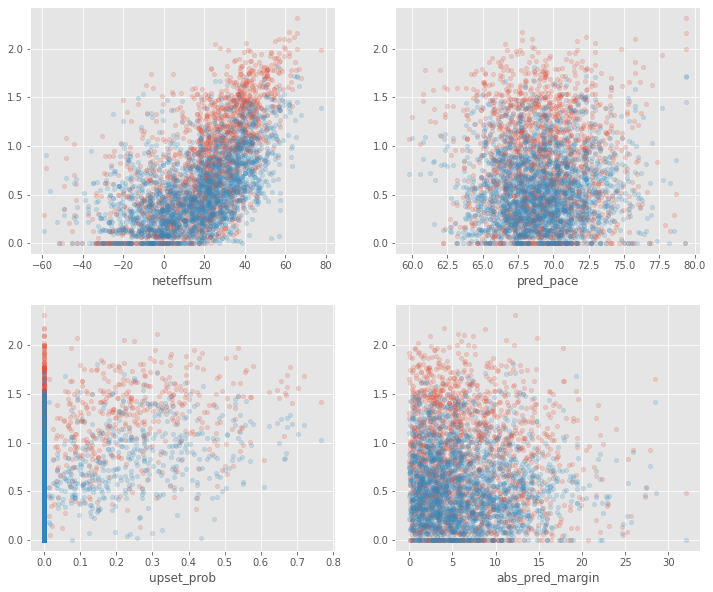

In [18]:
fig,axs = plt.subplots(2,2,figsize=(12,10))
axs = axs.flatten()
ip = merged.is_postgame
for i,var in enumerate(['neteffsum','pred_pace','upset_prob','abs_pred_margin']):
    axs[i].scatter(merged[~ip][var], np.log10(merged[~ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].scatter(merged[ ip][var], np.log10(merged[ ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].set_xlabel(var)
    print(np.corrcoef(merged[ip][var], np.log10(merged[ip].norm_num_comments+1))[0,1])

In [19]:
merged.groupby('gid').mean().reset_index()

,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,neteffsum,prob,pred_margin,pred_pace,rank1,rank2,upset_prob,abs_pred_margin,is_rivalry
0,2018-02-03_cincinnati_connecticut,0.5,56.5,191.0,426.0,9.253980,27.989495,0.894086,12.760096,66.956162,8.0,-1.0,0.105914,12.760096,0.0
1,2018-02-03_colorado-state_nevada,0.5,9.0,5.0,92.0,0.521286,18.823802,0.144644,-12.714787,70.820185,-1.0,-1.0,0.000000,12.714787,0.0
2,2018-02-04_arizona-state_washington-state,0.0,9.0,39.0,216.0,2.653614,22.030104,0.796967,8.409091,72.574136,25.0,-1.0,0.000000,8.409091,0.0
3,2018-02-04_boston-college_georgia-tech,0.5,6.5,12.5,124.0,1.122533,16.601461,0.742531,6.130176,67.331781,-1.0,-1.0,0.000000,6.130176,0.0
4,2018-02-04_illinois_ohio-state,0.5,66.0,216.5,773.0,7.786964,33.990271,0.175144,-10.243978,70.674257,-1.0,17.0,0.175144,10.243978,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,2020-03-11_kansas-state_texas-christian,0.0,8.0,80.0,238.0,5.185630,21.886055,0.472909,-1.220732,65.748976,-1.0,-1.0,0.000000,1.220732,0.0
2450,2020-03-11_minnesota_northwestern,0.0,13.0,162.0,311.0,9.186177,23.787241,0.783746,8.205395,66.502295,-1.0,-1.0,0.000000,8.205395,0.0
2451,2020-03-11_north-carolina-state_pittsburgh,0.0,22.0,308.0,530.0,13.378665,20.706276,0.537374,1.091810,66.926473,-1.0,-1.0,0.000000,1.091810,0.0
2452,2020-03-11_north-carolina_syracuse,0.0,43.0,1062.0,1054.0,32.711783,21.934308,0.484825,-2.878391,70.371018,-1.0,-1.0,0.000000,2.878391,0.0


[0.02698182 1.02330407 0.00116979 0.35788329] 0.9642921149645456


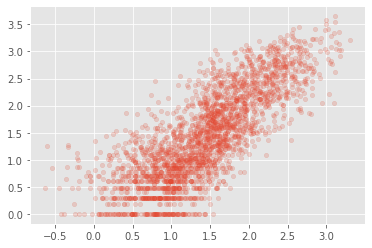

In [20]:
consol = merged.groupby('gid').mean().reset_index()
X = np.array([consol.neteffsum, consol.upset_prob, consol.abs_pred_margin, consol.is_rivalry]).T
y = np.log10(consol.num_comments + 1)
linreg.fit(X,y)
pred = linreg.predict(X)
print(linreg.coef_, linreg.intercept_)

consol["score"] = 10**(pred)-1

plt.figure()
plt.scatter(pred, y, s=20, alpha=0.2)

In [21]:
d1 = dt.date(2020,2,16)
d2 = dt.date(2020,2,23)
def between_dates(gid):
    date = dt.date(*[int(x) for x in gid.split('_')[0].split('-')])
    if d1 <= date and date < d2:
        return True
    return False

consol[['gid','num_comments','norm_num_comments','is_rivalry','neteffsum','abs_pred_margin','upset_prob','score']] \
    .sort_values('score', ascending=False) \
    .loc[consol.gid.apply(between_dates)].head(20)

,gid,num_comments,norm_num_comments,is_rivalry,neteffsum,abs_pred_margin,upset_prob,score
2086,2020-02-22_brigham-young_gonzaga,799.0,47.245860,0.0,50.630821,1.569795,0.404111,555.888782
2098,2020-02-22_florida_kentucky,436.0,14.647706,1.0,37.611478,3.682212,0.381258,537.830301
2016,2020-02-18_kentucky_louisiana-state,531.5,18.686545,0.0,37.025158,2.530231,0.667559,445.040659
2083,2020-02-22_baylor_kansas,1534.0,54.577271,0.0,61.696171,0.985580,0.000000,425.697660
2013,2020-02-18_dayton_virginia-commonwealth,187.5,12.555929,0.0,39.212688,2.811132,0.450461,305.597729
2008,2020-02-18_baylor_oklahoma,164.5,10.383148,0.0,42.246384,3.745866,0.358396,297.748818
2015,2020-02-18_illinois_penn-state,810.5,33.481446,0.0,41.093995,4.676872,0.326507,257.624849
2121,2020-02-22_villanova_xavier,37.0,2.146958,0.0,34.784323,1.227064,0.479351,247.195656
2111,2020-02-22_marquette_providence,128.0,9.567169,0.0,31.267780,1.067643,0.547177,232.954135
2035,2020-02-19_duke_north-carolina-state,1038.5,34.830172,0.0,42.897984,9.226269,0.218126,225.861000


In [24]:
with open('../models/reddit_regression.pkl', 'wb') as fid:
    pickle.dump(linreg, fid)